In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.special import gamma
from typing import Tuple
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from scipy.stats import gennorm

In [4]:
# Load the CSV file
df = pd.read_csv("../data/cleanv3_transform.csv")

In [ ]:
# # Filter out rows where 'INCZERO_ONE' or 'INCZERO_TWO' are equal to 1
# df_filtered = df[(df['INCZERO_ONE'] != 1) & (df['INCZERO_TWO'] != 1)]

# # Build the main dataframe with continuous target and predictors.
# # NOTE: A factor has been added to center the peak of the target distribution at 0.
# #       This factor must be removed at the end to obtain the final predictions.
# df_data = pd.DataFrame({
#     "target": df_filtered["INCLOG_DELTA"],
#     "INCTOT": df_filtered["INCTOT"],
#     "EDUC": df_filtered["EDUC"],
#     "INCPER": df_filtered["INCPER"],
#     "AGE": df_filtered["AGE"],
#     "UHRSWORKLY": df_filtered["UHRSWORKLY"],
#     "INCWAGE": df_filtered["INCWAGE"],
#     "FTOTVAL": df_filtered["FTOTVAL"]
# })

# # Append additional continuous features (columns starting with "occ_" or "ind_")
# df_data = pd.concat([df_data, df_filtered.filter(regex="^(occ_|ind_)")], axis=1)

# # One-hot encode categorical features and add them as predictors.
# categorical_features = ["LABFORCE", "EMPSTAT", "SEX"]
# df_cat = pd.get_dummies(df_filtered[categorical_features], drop_first=False)
# df_data = pd.concat([df_data, df_cat], axis=1)

In [ ]:
# X = df_data.drop(columns=["target"])
# y = df_data["target"]

# # Split into training and validation sets.
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# dval = xgb.DMatrix(X_val, label=y_val)
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dall = xgb.DMatrix(X, label=y)

In [5]:
# Filter out rows where 'INCZERO_ONE' or 'INCZERO_TWO' are equal to 1
df_filtered = df[(df['INCZERO_ONE'] != 1) & (df['INCZERO_TWO'] != 1)]

# Build the main dataframe with continuous target and predictors.
df_data = pd.DataFrame({
    "target": df_filtered["INCLOG_DELTA"],
})

continuous_features = ['INCWAGE', 'INCPER', 'EDUC', 'INCTOT', 'NCHILD', 'HEALTH', 'FTOTVAL', 'INCSS', 'AGE', 'INCSSI']
df_cont = df_filtered[continuous_features].copy()

# Append additional continuous features (columns starting with "occ_" or "ind_")
df_hccat = pd.concat([df_filtered.filter(regex="^(occ_|occly_|ind_|indly_)")], axis=1)

# One-hot encode categorical features and add them as predictors.
categorical_features = ['PENSION', 'NATIVITY', 'EMPSTAT', 'SCHLCOLL', 'FAMREL', 'RELATE', 'DIFFHEAR', 'FAMKIND', 'DISABWRK', 'MARST', 'SEX', 'DIFFANY', 'FTYPE', 'LABFORCE', 'MIGRATE1']
ohe = OneHotEncoder(sparse_output=False)
encoded_array = ohe.fit_transform(df_filtered[categorical_features])
encoded_col_names = ohe.get_feature_names_out(categorical_features)
df_cat = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_filtered.index)

df_data = pd.concat([df_data, df_cont, df_hccat, df_cat], axis=1)

X_all = df_data.drop(columns=["target"])
y_all = df_data["target"]

# Split into training and validation sets.
X, X_test, y, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Split into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)
dtrain = xgb.DMatrix(X_train, label=y_train)
dall = xgb.DMatrix(X, label=y)

In [ ]:
# Set beta to 0.8 (the only free parameter, with unit scale)
beta = 0.85
eps  = 1e-12  # Small constant for numerical stability

def gnd_objective_func(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculates alpha-independent gradient and hessian for GND loss.
        """
        y_true = dtrain.get_label()
        diff = y_true - predt
        abs_diff = np.abs(diff)

        # Calculate (|abs_diff| + eps)^(beta - 2) term, crucial for grad and hess
        # Epsilon is vital for stability when beta <= 2
        pow_beta_minus_2 = np.power(abs_diff + eps, beta - 2)

        # --- Gradient Calculation (alpha-independent) ---
        # g_no_alpha = -beta * diff * pow_beta_minus_2
        grad = -beta * diff * pow_beta_minus_2

        # --- Hessian Calculation (alpha-independent) ---
        if beta > 1:
            # h_no_alpha = beta * (beta - 1) * pow_beta_minus_2
            hess = beta * (beta - 1) * pow_beta_minus_2
        elif beta == 1:
            # Replicate reg:absoluteerror behavior
            hess = np.ones_like(predt)
        else: # 0 < beta < 1
            # Use scaled positive approximation
            # h_no_alpha = beta * (1 - beta) * pow_beta_minus_2
            hess = beta * (1 - beta) * pow_beta_minus_2

        # --- Final Hessian Stabilization ---
        # Ensure Hessian is reasonably positive (floor it)
        # Important safeguard, especially for beta <= 1 cases.
        hess = np.maximum(hess, eps)

        return grad, hess

def generalized_normal_metric(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    """
    Custom evaluation metric that reports the average full negative log likelihood (nll) for the 
    generalized normal model with unit scale. The full per-example nll (including its constant part) is:
    
        nll = log(2 * Gamma(1/BETA) / BETA) + |y - pred|^BETA
    """
    y = dtrain.get_label()
    nll = (np.abs(y - predt) ** beta)
    return "gnll", float(np.mean(nll))

In [68]:
xgb_params = {
    "tree_method": "hist",
    "learning_rate": 0.1,
    "max_depth": 3,
    "min_child_weight": 5000,         # require more instances to make a split
    # "gamma": 1,                  # higher minimum loss reduction for a split
    # "subsample": 0.5,              # use 80% of the samples per tree
    # "colsample_bytree": 0.8,       # use 80% of the features per tree
    # "reg_alpha": 0,              # L1 regularization
    # "reg_lambda": 0,             # L2 regularization
    "verbosity": 1,
    # No "objective" specified; we pass our custom objective.
}

In [69]:
num_round = 5000  # Number of boosting rounds

# Use xgb.train() with our custom objective and evaluation metric.
bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    obj=gnd_objective_func,
    custom_metric = generalized_normal_metric,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-rmse:0.55142	train-gnll:0.46353	val-rmse:0.55240	val-gnll:0.46406
[50]	train-rmse:0.31309	train-gnll:0.21102	val-rmse:0.31343	val-gnll:0.21177
[100]	train-rmse:0.31030	train-gnll:0.20930	val-rmse:0.31076	val-gnll:0.21030
[150]	train-rmse:0.30911	train-gnll:0.20843	val-rmse:0.30977	val-gnll:0.20966
[200]	train-rmse:0.30840	train-gnll:0.20778	val-rmse:0.30926	val-gnll:0.20927
[250]	train-rmse:0.30785	train-gnll:0.20727	val-rmse:0.30888	val-gnll:0.20901
[300]	train-rmse:0.30734	train-gnll:0.20682	val-rmse:0.30858	val-gnll:0.20884
[350]	train-rmse:0.30700	train-gnll:0.20645	val-rmse:0.30842	val-gnll:0.20867
[400]	train-rmse:0.30666	train-gnll:0.20608	val-rmse:0.30825	val-gnll:0.20852
[450]	train-rmse:0.30636	train-gnll:0.20581	val-rmse:0.30808	val-gnll:0.20845
[500]	train-rmse:0.30615	train-gnll:0.20553	val-rmse:0.30801	val-gnll:0.20838
[550]	train-rmse:0.30595	train-gnll:0.20528	val-rmse:0.30791	val-gnll:0.20830
[600]	train-rmse:0.30569	train-gnll:0.20505	val-rmse:0.30779	val-gn

In [ ]:
bst.save_model("xgb_gnd.bin")

C:\Users\nickb\AppData\Local\Temp\ipykernel_34104\1651853195.py:1: UserWarning: [15:29:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  bst.save_model("xgb_gnd.bin")


: 

Fitted parameters:
Shape (beta): 1
Location (mu): 0
Scale (alpha): 0.2034729021598532


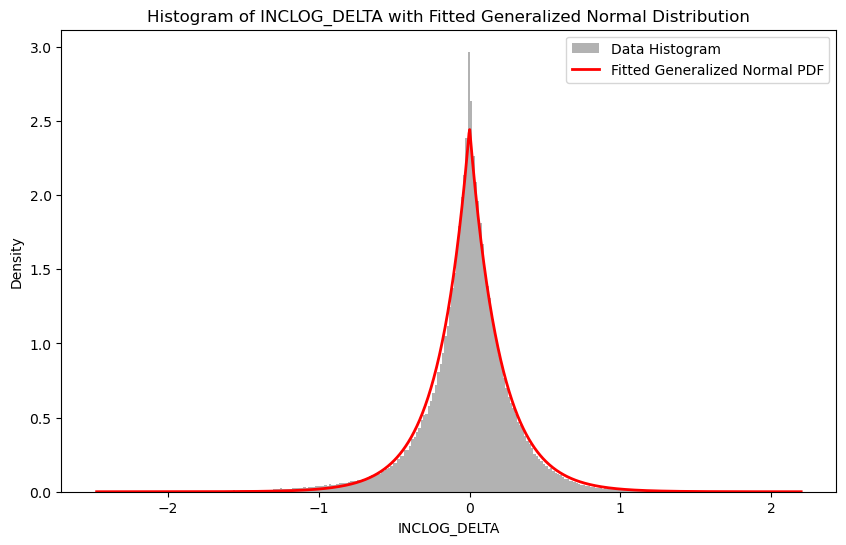

In [70]:
# Now predict on the training data (or on a held-out test set if available)
y_pred_train = bst.predict(dtrain)

# Assume df_data is your DataFrame and it contains the column "INCLOG_DELTA"
# Remove any missing values and get the data as a numpy array
data = y_train - y_pred_train

# Fit the generalized normal distribution to the data.
# The fit function returns the shape parameter (often called beta),
# as well as the location (mu) and scale (alpha) parameters.
shape, loc, scale = gennorm.fit(data, f0=beta, floc=0)
print("Fitted parameters:")
print("Shape (beta):", shape)
print("Location (mu):", loc)
print("Scale (alpha):", scale)

alpha_fit = scale

# Generate a sequence of x values over the range of the data to later evaluate the PDF.
x = np.linspace(data.min(), data.max(), 1000)
pdf_values = gennorm.pdf(x, shape, loc=loc, scale=scale)

# Plot the density histogram and the fitted PDF.
plt.figure(figsize=(10, 6))
plt.hist(data, bins=300, density=True, alpha=0.6, color='gray', label='Data Histogram')
plt.plot(x, pdf_values, 'r-', lw=2, label='Fitted Generalized Normal PDF')
plt.xlabel('INCLOG_DELTA')
plt.ylabel('Density')
plt.title('Histogram of INCLOG_DELTA with Fitted Generalized Normal Distribution')
plt.legend()
plt.show()

Mean Log-likelihood of the data: 1.711313258155656


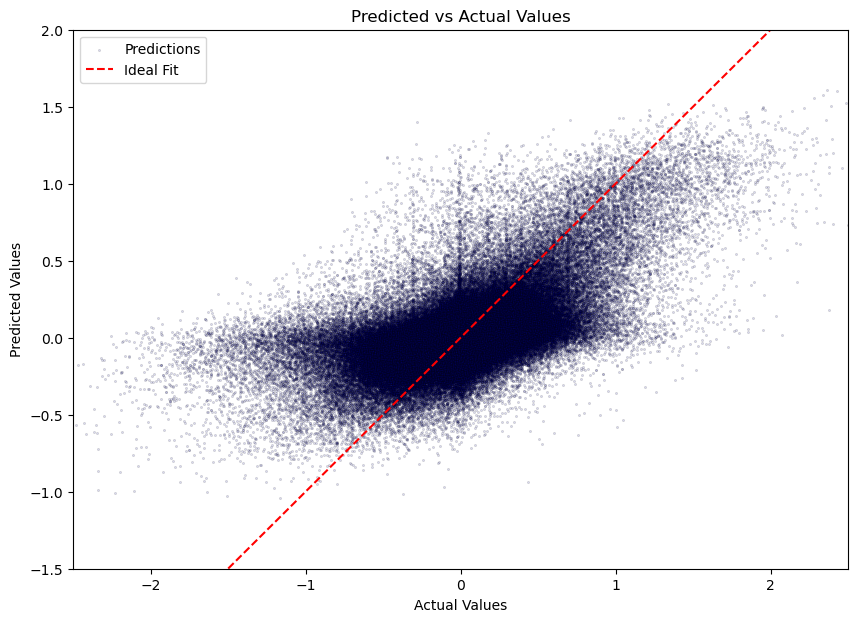

Mean Absolute Error (MAE): 0.20347544854993532
Mean Log-likelihood of the data: 1.4912851885713696


In [71]:
# Plot predicted vs. actual values:
plt.figure(figsize=(10, 7))
plt.scatter(y_train, y_pred_train, c="darkblue", alpha=0.15, edgecolors="black", linewidth=0.5, s=2.5, label="Predictions")
# Plot an ideal 45-degree line (y=x) for reference.
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label="Ideal Fit")
plt.xlim(-2.5, 2.5)
plt.ylim(-1.5, 2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

# Compute the mean absolute error.
mae = mean_absolute_error(y_train, y_pred_train)
print("Mean Absolute Error (MAE):", mae)

# Compute the mean log-likelihood
N_train = len(y_train)

log_likelihood = np.log(beta / (2 * alpha_fit * gamma(1 / beta))) - np.log(alpha_fit) - 1/(N_train * alpha_fit ** beta) * np.sum(np.abs(y_train - y_pred_train) ** beta)

print("Mean Log-likelihood of the data:", log_likelihood)

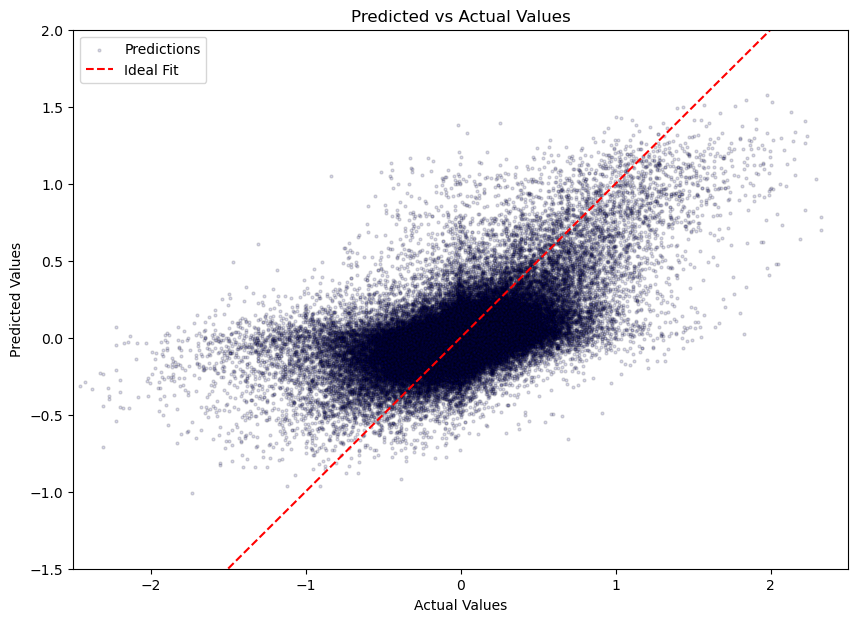

Mean Absolute Error (MAE): 0.207463609443186
Mean Log-likelihood of the data: 1.4716847363690537


In [72]:
# Now predict on the training data (or on a held-out test set if available)
y_pred_test = bst.predict(dtest)

# Plot predicted vs. actual values:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred_test, c="darkblue", alpha=0.15, edgecolors="black", linewidth=0.89, s=4.47, label="Predictions")
# Plot an ideal 45-degree line (y=x) for reference.
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlim(-2.5, 2.5)
plt.ylim(-1.5, 2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

# Compute the mean absolute error.
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

# Compute the mean log-likelihood
N_test = len(y_test)

log_likelihood = np.log(beta / (2 * alpha_fit * gamma(1 / beta))) - np.log(alpha_fit) - 1/(N_test * alpha_fit ** beta) * np.sum(np.abs(y_test - y_pred_test) ** beta)

print("Mean Log-likelihood of the data:", log_likelihood)

In [107]:
from sklearn.metrics import mean_absolute_error
# Compute the mean absolute error.
mae = mean_absolute_error(y, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.20553061050067362
